<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/image/categorize/Human_action_rec/Human_action_rec_VGG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

In [3]:
#!pip install --user tensorflow-addons==0.8.3
#!pip install --user tensorflow==2.2.0-rc3

In [ ]:
import tensorflow_addons as tfa #애드온 옵티마이저
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from PIL import Image           # 이미지 처리와 그래픽 기능 제공 라이브러리

from tensorflow.keras.utils import to_categorical 
# to_categorical 함수 설명
'''
-- 입력 받은 n 차원 크기의 1차원 정수배열을 (n,k)크기의 2차원 배열로 변경
-- 클래스 수 만큼의 열을 가진 행렬로 변환
-- 클래스 벡터(정수)를 이진 클래스 행렬로 변환
'''
# 원핫 인코딩하는데 사용

In [5]:
train_csv = pd.read_csv('/content/drive/MyDrive/kaggle/Human_Action_Recognition/Training_set.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/kaggle/Human_Action_Recognition/Testing_set.csv')

In [6]:
train_fol = glob.glob('/content/drive/MyDrive/kaggle/Human_Action_Recognition/train/*')
test_fl = glob.glob('/content/drive/MyDrive/kaggle/Human_Action_Recognition/test/*')
# glob.glob() : glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환

In [7]:
train_csv

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [8]:
train_csv.label.value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

-> 라벨의 값이 균형있게 분포하고 있는 것을 확인할 수 있음

In [9]:
# plotly 사용해보기
import plotly.express as px
l = train_csv.label.value_counts()
fig = px.pie(train_csv, values=l.values, names=l.index, title='Human Activity Distribution')
fig.show()

In [10]:
# filename 추출
filename = train_csv['filename']

# situation 추출
situation = train_csv['label']

In [11]:
def disp():
  num = random.randint(1,10000)
  imgg = "Image_{}.jpg".format(num)
  train = '/content/drive/MyDrive/kaggle/Human_Action_Recognition/train/'

  if os.path.exists(train+imgg):
    testImage = img.imread(train+imgg)  # 파일 불러올 수 있음
    plt.imshow(testImage)
    plt.title('{}'.format(train_csv.loc[train_csv['filename']=='{}'.format(imgg),'label'].item())) 

  else:
    # print(train+img)
    print("File Path not found \n Skipping the file!")

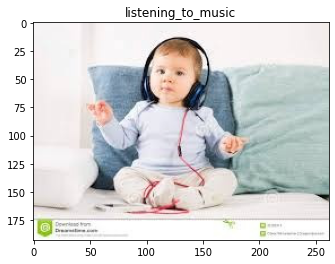

In [32]:
disp()

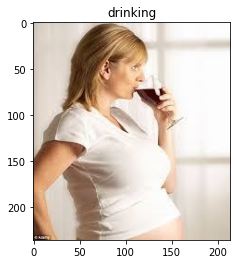

In [31]:
disp()

### preprocessing image data

In [14]:
img_data = []
img_label = []

length = len(train_fol)

for i in (range(len(train_fol)-1)):
  t = '/content/drive/MyDrive/kaggle/Human_Action_Recognition/train/'+filename[i]

  # 이미지 open
  temp_img = Image.open(t)
  # 이미지 저장 및 사이즈 조정
  # np.asarray() : 
  # ㄴ # np.array와 다른 점은 이미 nparray 형식일 경우 복사하지 않음
  # ㄴ # np.array에서 copy를 False로 두는 것과 같음
  img_data.append(np.asarray(temp_img.resize((160,160))))
  # i 번째 라벨값 입력
  img_label.append(situation[i])

In [15]:
inp_shape = (160,160,3) # 이미지의 사이즈 (160,160)에 채널3(컬러) 

# img_data array로 변경
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [16]:
# 인코딩

y_train = to_categorical(np.asarray(train_csv['label'].factorize()[0]))
# pd.factorize() : 1. 정수로 인코딩 된 값, 2.인코딩 된 범주 반환
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
from keras.models import Sequential
vgg_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(include_top=False,
                                               input_shape=(160,160,3),
                                               pooling='avg',
                                               classes=15,
                                               weights='imagenet')

for layer in pretrained_model.layers:
  layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))

58900480/58889256 [==============================] - 0s 0us/step


In [18]:
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
history = vgg_model.fit(iii, y_train, epochs=3)

Epoch 1/3
394/394 [==============================] - 3176s 8s/step - loss: 2.2084 - accuracy: 0.4448
Epoch 2/3
394/394 [==============================] - 3187s 8s/step - loss: 1.2161 - accuracy: 0.5993
Epoch 3/3
394/394 [==============================] - 3194s 8s/step - loss: 0.9445 - accuracy: 0.6889


In [21]:
vgg_model.save_weights('model.h5')

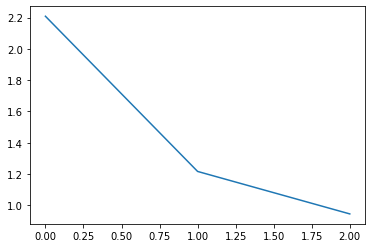

In [22]:
losses = history.history['loss']
plt.plot(losses)

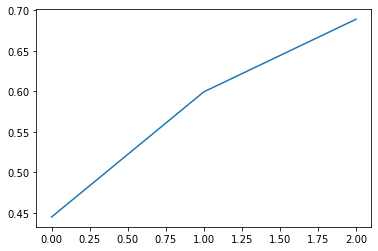

In [23]:
acc = history.history['accuracy']
plt.plot(acc)

### Predict

In [27]:
def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((160,160)))

In [28]:
# predict function

def test_predict(test_image):
  result = vgg_model.predict(np.asarray([read_image(test_image)]))

  itemindex = np.where(result==np.max(result))
  prediction = itemindex[1][0]
  print('probability: '+ str(np.max(result)*100) + '%\nPredicted class: ',prediction)

  image = img.imread(test_image)
  plt.imshow(image)
  plt.title(prediction)

probability: 69.51049566268921%
Predicted class:  4


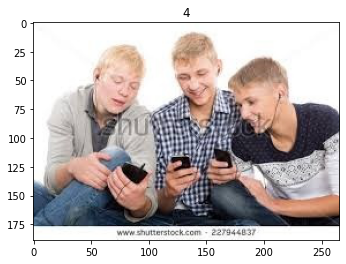

In [29]:
test_predict('/content/drive/MyDrive/kaggle/Human_Action_Recognition/test/Image_1010.jpg')